In [1]:
!pip install -q -U google-generativeai

In [10]:
pip install pdf2image

In [11]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (210 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


### Code

In [23]:
import google.generativeai as genai
from pdf2image import convert_from_path
import os
import csv
import json
import pandas as pd
from google.colab import userdata
import time
import re

# Google Generative AI setup (configure with your API key)

genai.configure(api_key='#######')

# Model configuration
MODEL_CONFIG = {
    "temperature": 0.2,
    "top_p": 1,
    "top_k": 32,
    "max_output_tokens": 4096,
}

# Safety settings
safety_settings = [
    {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"}
]

# Initialize the model
model = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=MODEL_CONFIG,
    safety_settings=safety_settings
)

# Convert PDF to images using Poppler
def pdf_to_images(pdf_path):
    images = convert_from_path(pdf_path)  # Convert PDF pages to images
    return images

# Function to format images for processing
def image_format(pdf_path):
    images = pdf_to_images(pdf_path)  # Convert PDF pages to images

    if not images:
        raise FileNotFoundError(f"Could not convert PDF: {pdf_path}")

    image_parts = []

    for img in images:
        # Save the image temporarily to bytes or any required format
        img_path = f"{os.path.splitext(pdf_path)[0]}_page.png"
        img.save(img_path, 'PNG')  # Save the image to PNG format
        with open(img_path, "rb") as f:
            image_data = f.read()

        image_parts.append({
            "mime_type": "image/png",  # Using PNG format for image
            "data": image_data         # Read the saved image as bytes
        })

    return image_parts



def gemini_output(image_path, system_prompt, user_prompt, retries=3):
    for attempt in range(retries):
        try:
            image_info = image_format(image_path)
            input_prompt = [system_prompt, image_info[0], user_prompt]
            response = model.generate_content(input_prompt)
            return response.text
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            if attempt < retries - 1:
                print("Retrying...")
                time.sleep(2)  # Delay before retrying
            else:
                print("Max retries reached. Skipping this PDF.")
                return None

# Process all PDFs in a folder
def process_pdfs_in_folder(folder_path, output_csv_path):
    # Prepare system and user prompts
    system_prompt = """
        You are a specialist in comprehending receipts.
        Input images in the form of receipts will be provided to you,
        and your task is to respond to questions based on the content of the input image.
    """
    user_prompt = """
        Convert Invoice data into JSON format with appropriate JSON tags as required for the data in the image.
        Review the input image and extract the following fields:
        Invoice # (INV-3digit)
        Invoice Date (DD-MM-YYYY)
        Due Date (DD-MM-YYYY)
        Total Items
        Taxable Amount
        Total
        Place of Supply
        GSTIN
        Example format:
        [
          "Invoice": INV-117,
          "Invoice Date": 01 Feb 2024,
          "Due Date": 29 Jan 2024,
          "Total Items": 3,
          "Taxable Items": 1483.32,
          "Total": 1667.00,
          "Place of Supply": 23-MADHYA PRADESH,
          "GSTIN": 23AADCU2395N1ZY
        ]
    """

    # Open the CSV file for writing
    with open(output_csv_path, mode='w', newline='') as csv_file:
        fieldnames = ['Invoice', 'Invoice Date', 'Due Date', 'Total Items', 'Taxable Amount', 'Total', 'Place of Supply', 'GSTIN']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()

        # Iterate over all PDF files in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith(".pdf"):
                pdf_path = os.path.join(folder_path, filename)
                print(pdf_path)
                try:
                    # Get the response from the model for each PDF
                    output = gemini_output(pdf_path, system_prompt, user_prompt)
                    # print(output)

                    # # Clean the output and parse as JSON
                    cleaned_output = output.lstrip('```json').rstrip('```').strip()
                    # json_data = json.loads(cleaned_output)
                    # print(cleaned_output)
                    cleaned_output = re.sub(r'"(\w+)":', r'"\1":', cleaned_output)  # Ensure keys are properly quoted
                    cleaned_output = "{" + cleaned_output[1:-1].strip() + "}"
                    # print(cleaned_output)

                    # # Clean the output and parse as JSON
                    # cleaned_output = output.lstrip('json').rstrip('}').strip()
                    # print(cleaned_output)

                    # Additional checks for JSON format
                    # if not cleaned_output.startswith('{'):
                    #     cleaned_output = "{" + cleaned_output
                    # if not cleaned_output.endswith('}'):
                    #     cleaned_output += "}"
                    # cleaned_output = re.sub(r'(\w+):', r'"\1":', cleaned_output)
                    # print(cleaned_output)
                    json_data = json.loads(cleaned_output)
                    # df = pd.DataFrame(json_data)

                    if isinstance(json_data, list):
                        for entry in json_data:
                            writer.writerow(entry)  # Write each dictionary to the CSV file
                    elif isinstance(json_data, dict):
                        writer.writerow(json_data)

                    # Write the JSON data to the CSV file
                    print(f"Done for {filename}")
                    time.sleep(1)

                except Exception as e:
                    print(f"Error processing {filename}: {e}")

# Folder containing the PDFs
folder_path = "/content/drive/MyDrive/zolvit_data/"  # Update this to your folder
output_csv_path = "/content/drive/MyDrive/zolvit_data/invoice_data_new.csv"

# Process the PDFs and store the output in a CSV file
process_pdfs_in_folder(folder_path, output_csv_path)
print(f"Invoice data extracted and saved to {output_csv_path}")

/content/drive/MyDrive/zolvit_data/INV-117_Naman.pdf
Done for INV-117_Naman.pdf
/content/drive/MyDrive/zolvit_data/INV-118_Rashu.pdf
Done for INV-118_Rashu.pdf
/content/drive/MyDrive/zolvit_data/INV-121_Jitesh Soni.pdf
Done for INV-121_Jitesh Soni.pdf
/content/drive/MyDrive/zolvit_data/INV-123_Asit.pdf
Done for INV-123_Asit.pdf
/content/drive/MyDrive/zolvit_data/INV-124_Ankita Sattva.pdf
Done for INV-124_Ankita Sattva.pdf
/content/drive/MyDrive/zolvit_data/INV-127_Avik Mallick.pdf
Done for INV-127_Avik Mallick.pdf
/content/drive/MyDrive/zolvit_data/INV-128_Atia Latif.pdf
Done for INV-128_Atia Latif.pdf
/content/drive/MyDrive/zolvit_data/INV-129_Divya Suhane.pdf
Done for INV-129_Divya Suhane.pdf
/content/drive/MyDrive/zolvit_data/INV-133_Sheetal Kapur.pdf
Done for INV-133_Sheetal Kapur.pdf
/content/drive/MyDrive/zolvit_data/INV-134_Sheetal Kapur.pdf
Done for INV-134_Sheetal Kapur.pdf
/content/drive/MyDrive/zolvit_data/INV-135_Mohith Saragur.pdf
Done for INV-135_Mohith Saragur.pdf
/conte

### Evaluation

In [2]:
import pandas as pd
from datetime import datetime
import re

# Load the ground truth and OCR results
ground_truth_df = pd.read_excel('/content/drive/MyDrive/zolvit_data/gt_ocr_new.xlsx')
ocr_results_df = pd.read_csv('/content/drive/MyDrive/zolvit_data/invoice_data_new.csv')
# print("Available columns in ocr_results_df:", ocr_results_df.columns)
# print("Available columns in ocr_results_df:", ground_truth_df.columns)
ground_truth_df.head(2)


,Invoice,Invoice Date,Due Date,Total Items,Taxable Amount,Total,Place of Supply,GSTIN
0,INV-149,2024-03-22,2024-04-01,1,370.64,437,23-MADHYA PRADESH,3AADCU2395N1ZY
1,INV-148,2024-03-30,2024-04-01,2,1076.40,1234,23-MADHYA PRADESH,23AADCU2395N1ZY


In [3]:
ocr_results_df.head(2)

,Invoice,Invoice Date,Due Date,Total Items,Taxable Amount,Total,Place of Supply,GSTIN
0,INV-117,01 Feb 2024,29 Jan 2024,3,"1,483.32","1,667.00",23-MADHYA PRADESH,23AADCU2395N1ZY
1,INV-118,30 Jan 2024,30 Jan 2024,1,350.00,350.00,23-MADHYA PRADESH,23AADCU2395N1ZY


In [4]:
import pandas as pd
from datetime import datetime
import re

# Load the ground truth and OCR results
ground_truth_df = pd.read_excel('/content/drive/MyDrive/zolvit_data/gt_ocr_new.xlsx')
ocr_results_df = pd.read_csv('/content/drive/MyDrive/zolvit_data/invoice_data_new.csv')

# Normalize text data by converting to lowercase, trimming spaces, etc.
def normalize_text(text):
    if pd.isna(text):
        return text
    return str(text).strip().lower()

# Function to normalize cost fields
def normalize_cost(cost_text):
    if pd.isna(cost_text):
        return None
    # Convert to string and strip any extra spaces
    cost_text = str(cost_text).strip()
    # Remove commas and currency symbols (e.g., ₹, $) using regex
    cost_text = re.sub(r'[,\$₹]', '', cost_text)
    # Convert to float if it contains decimals or integer otherwise
    try:
        return round(float(cost_text), 2)  # round to 2 decimal places for consistency
    except ValueError:
        return None

# Normalize the date fields
def normalize_date(date_text):
    if pd.isna(date_text):
        return None
    # Define possible formats for input dates
    possible_formats = ['%Y-%m-%d', '%d %b %Y', '%d-%b-%Y', '%d %B %Y']
    for date_format in possible_formats:
        try:
            # Try parsing the date using each format
            normalized_date = datetime.strptime(str(date_text).strip(), date_format)
            return normalized_date.strftime('%Y-%m-%d')  # Convert to 'YYYY-MM-DD' format
        except ValueError:
            continue
    return date_text  # If no format matches, return the original value

# Function to calculate TP, FP, FN for a given field
def calculate_metrics(gt_values, ocr_values):
    gt_values = [str(gt).strip() for gt in gt_values]
    ocr_values = [str(ocr).strip() for ocr in ocr_values]
    tp = sum(gt == ocr for gt, ocr in zip(gt_values, ocr_values))
    fp = sum(gt != ocr for gt, ocr in zip(gt_values, ocr_values) if pd.notna(ocr))
    fn = sum(pd.isna(ocr) for ocr in ocr_values)
    tn = 0  # Not applicable
    return tp, fp, fn, tn

# List of fields to evaluate and their normalization functions
fields = [
    ('Invoice', normalize_text),
    ('Invoice Date', normalize_date),
    ('Due Date', normalize_date),
    ('Total Items', normalize_text),
    ('Taxable Amount', normalize_cost),
    ('Total', normalize_cost),
    ('Place of Supply', normalize_text),
    ('GSTIN', normalize_text),

]

# Dictionary to store metrics for each field
metrics = {'precision': {}, 'recall': {}, 'f1_score': {}}
ocr_results_df.columns = ocr_results_df.columns.str.strip() #.str.lower().str.replace(' ', '_')
ground_truth_df.columns = ground_truth_df.columns.str.strip()#.str.lower().str.replace(' ', '_')
# print("Available columns in ocr_results_df:", ocr_results_df.columns)
# print("Available columns in ocr_results_df:", ground_truth_df.columns)

# Iterate through each field and calculate metrics
for field, normalization_func in fields:
  # print(fields)
  # Get ground truth and OCR values for the current field
  if field == 'Invoice Date' or field== 'Due Date':
      # print(ground_truth_df[f'{field}'].apply(normalization_func))
      # print(ocr_results_df[f'{field}'].apply(normalization_func))
      # break
      gt_values = ground_truth_df[f'{field}'].apply(normalization_func).astype(str)
      ocr_values = ocr_results_df[f'{field}'].apply(normalization_func).astype(str)
  else:
      gt_values = ground_truth_df[f'{field}'].apply(normalization_func)#.astype(str)
      ocr_values = ocr_results_df[f'{field}'].apply(normalization_func)#.astype(str)

  # Calculate TP, FP, FN for the field
  tp, fp, fn, tn = calculate_metrics(gt_values, ocr_values)

  # Calculate precision, recall, and F1-score
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  # Store the results for the current field
  metrics['precision'][field] = precision
  metrics['recall'][field] = recall
  metrics['f1_score'][field] = f1_score

# Calculate average precision, recall, and F1-score across all fields
average_precision = sum(metrics['precision'].values()) / len(fields)
average_recall = sum(metrics['recall'].values()) / len(fields)
average_f1_score = sum(metrics['f1_score'].values()) / len(fields)

# Display metrics for each field and the overall averages
print("Field-wise Metrics:")
for field in fields:
    field_name = field[0]
    print(f"{field_name}: Precision: {metrics['precision'][field_name]:.2f}, "
          f"Recall: {metrics['recall'][field_name]:.2f}, "
          f"F1-Score: {metrics['f1_score'][field_name]:.2f}")

print("\nOverall Average Metrics:")
print(f"Average Precision: {average_precision:.2f}")
print(f"Average Recall: {average_recall:.2f}")
print(f"Average F1-Score: {average_f1_score:.2f}")

Field-wise Metrics:
Invoice: Precision: 0.04, Recall: 1.00, F1-Score: 0.08
Invoice Date: Precision: 0.17, Recall: 1.00, F1-Score: 0.29
Due Date: Precision: 0.21, Recall: 1.00, F1-Score: 0.34
Total Items: Precision: 0.21, Recall: 1.00, F1-Score: 0.34
Taxable Amount: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Total: Precision: 0.04, Recall: 1.00, F1-Score: 0.08
Place of Supply: Precision: 0.92, Recall: 1.00, F1-Score: 0.96
GSTIN: Precision: 0.96, Recall: 1.00, F1-Score: 0.98

Overall Average Metrics:
Average Precision: 0.32
Average Recall: 0.88
Average F1-Score: 0.38


### Plots

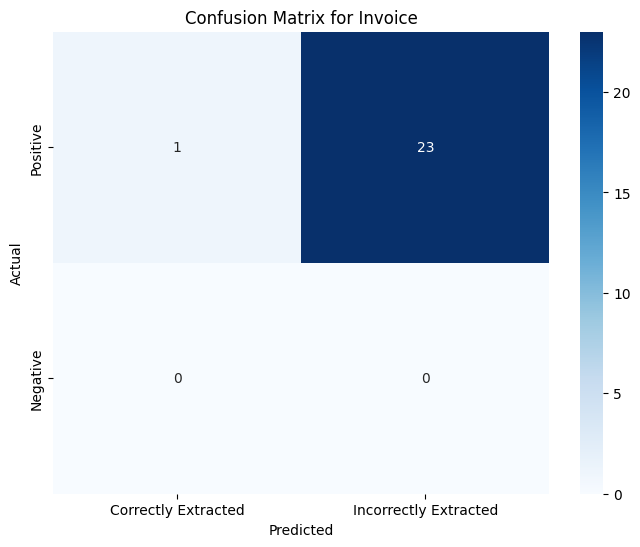

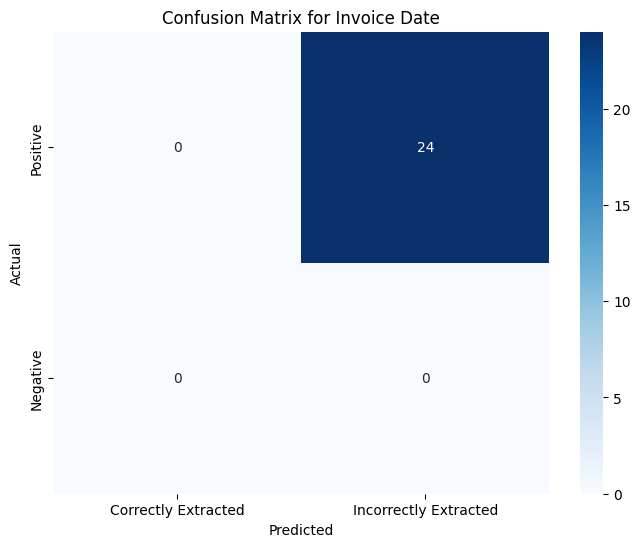

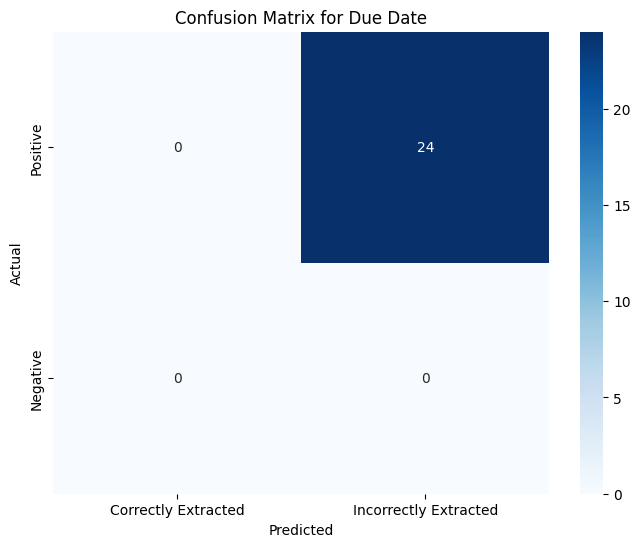

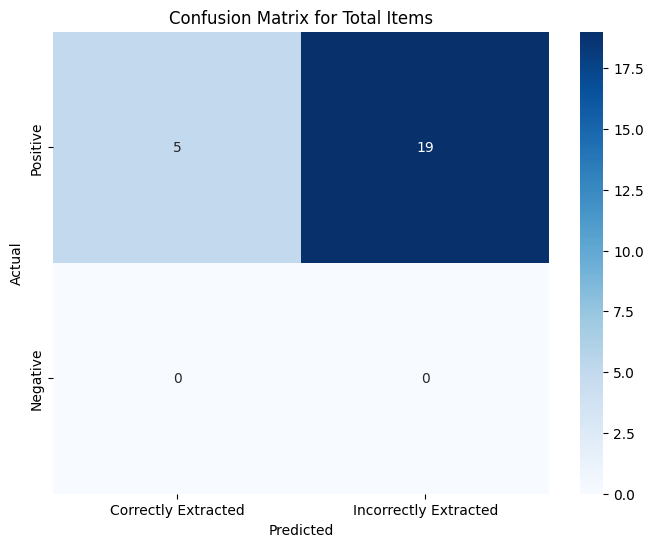

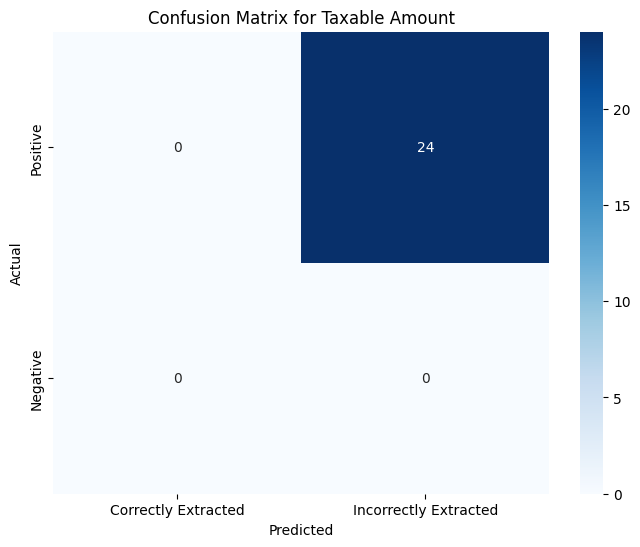

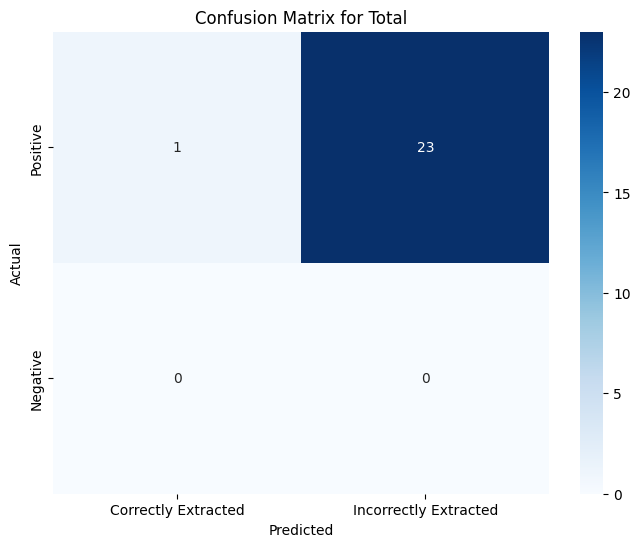

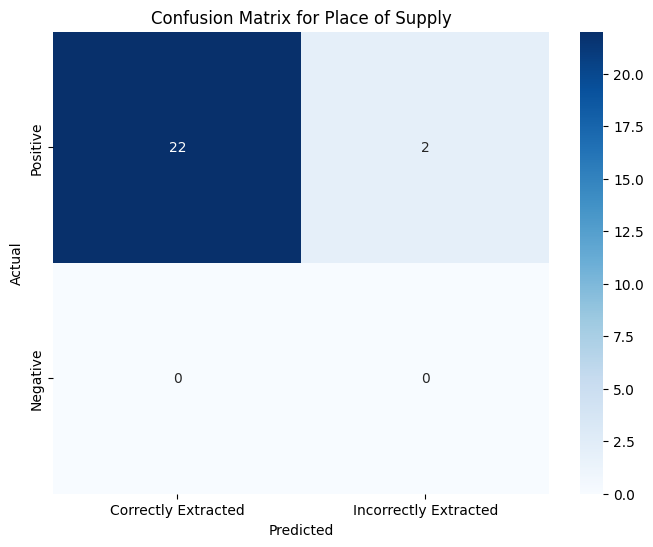

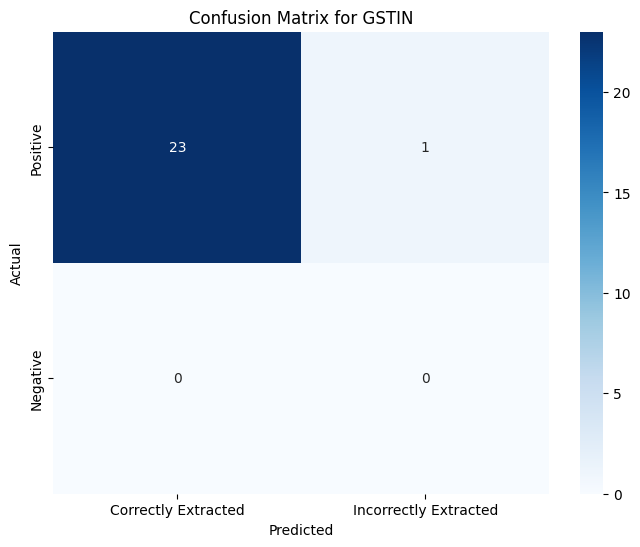

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the confusion matrix for a given field
def plot_confusion_matrix(tp, fp, fn, tn, field_name):
    # Create confusion matrix array
    confusion_matrix = np.array([[tp, fp], [fn, tn]])

    # Define labels
    labels = ['Correctly Extracted', 'Incorrectly Extracted']
    categories = ['Positive', 'Negative']

    # Plot the heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=categories)

    # Add titles and labels
    plt.title(f'Confusion Matrix for {field_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Show plot
    plt.show()

# Example: Plotting the confusion matrix for each field
for field, normalization_func in fields:
    # Get ground truth and OCR values for the current field
    gt_values = ground_truth_df[f'{field}'].apply(normalization_func)
    ocr_values = ocr_results_df[f'{field}'].apply(normalization_func)

    # Calculate TP, FP, FN for the field
    tp, fp, fn, tn = calculate_metrics(gt_values, ocr_values)

    # Plot confusion matrix
    plot_confusion_matrix(tp, fp, fn, tn, field)

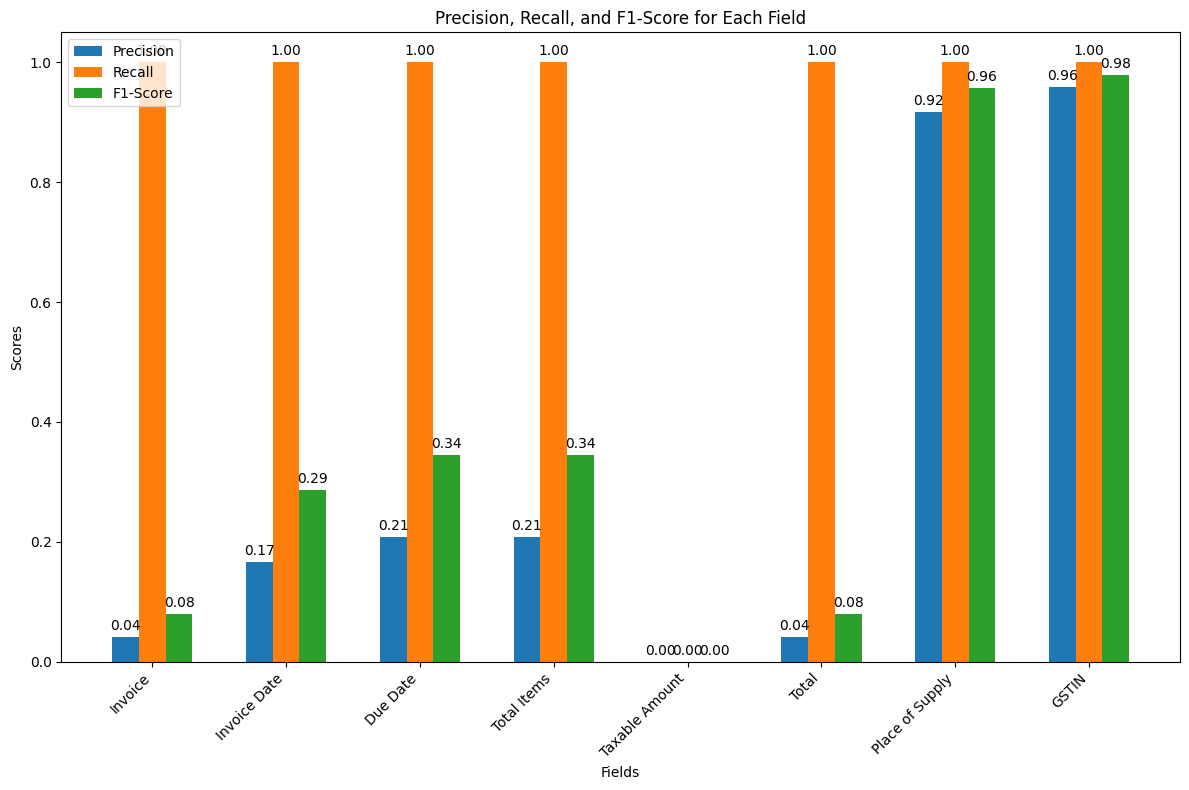

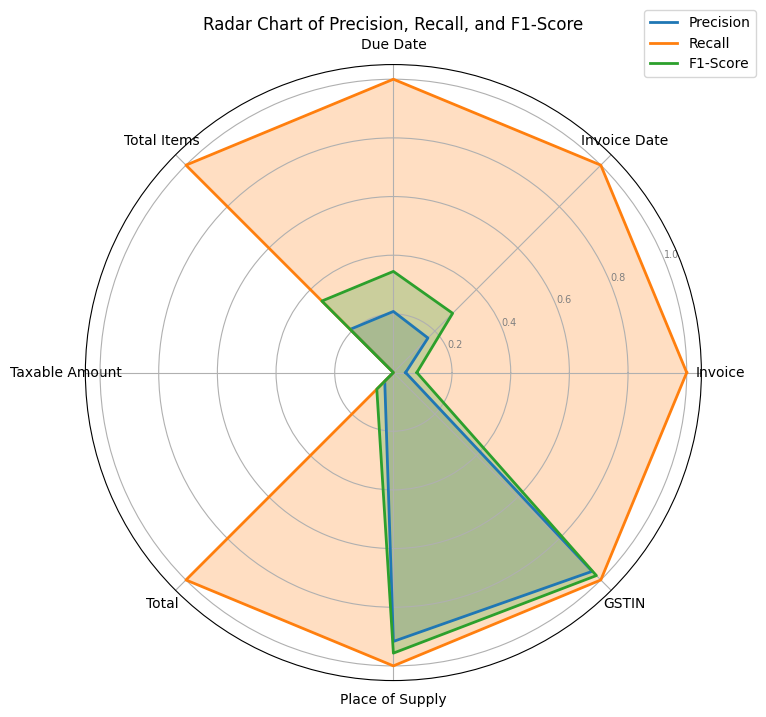

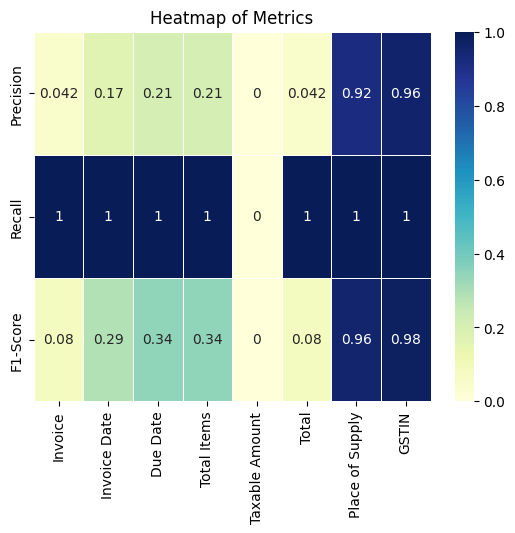

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
fields_list = [field[0] for field in fields]
precision_values = [metrics['precision'][field] for field in fields_list]
recall_values = [metrics['recall'][field] for field in fields_list]
f1_score_values = [metrics['f1_score'][field] for field in fields_list]

# Bar Plot for Precision, Recall, and F1-Score
x = np.arange(len(fields_list))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
bar1 = ax.bar(x - width, precision_values, width, label='Precision')
bar2 = ax.bar(x, recall_values, width, label='Recall')
bar3 = ax.bar(x + width, f1_score_values, width, label='F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Fields')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for Each Field')
ax.set_xticks(x)
ax.set_xticklabels(fields_list, rotation=45, ha="right")
ax.legend()

# Add value labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.tight_layout()
plt.show()

#  Radar Chart for Precision, Recall, and F1-Score
from math import pi

# Prepare data for radar plot
categories = fields_list
N = len(categories)

values_precision = precision_values + precision_values[:1]
values_recall = recall_values + recall_values[:1]
values_f1 = f1_score_values + f1_score_values[:1]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values_precision, linewidth=2, linestyle='solid', label='Precision')
ax.fill(angles, values_precision, alpha=0.25)

ax.plot(angles, values_recall, linewidth=2, linestyle='solid', label='Recall')
ax.fill(angles, values_recall, alpha=0.25)

ax.plot(angles, values_f1, linewidth=2, linestyle='solid', label='F1-Score')
ax.fill(angles, values_f1, alpha=0.25)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=7)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Radar Chart of Precision, Recall, and F1-Score')
plt.show()

#  Heatmap of Precision, Recall, and F1-Score
import seaborn as sns

data = np.array([precision_values, recall_values, f1_score_values])
sns.heatmap(data, annot=True, xticklabels=fields_list, yticklabels=['Precision', 'Recall', 'F1-Score'], cmap='YlGnBu', linewidths=0.5)

plt.title('Heatmap of Metrics')
plt.show()
